In [1]:
import zipfile

zip_path = "/content/asl_subset.zip"
extract_path = "/content/asl_subset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Archivos extraídos en {extract_path}")


Archivos extraídos en /content/asl_subset


In [2]:
!ls /content/asl_subset/archive/asl_alphabet_test/asl_alphabet_test




A_test.jpg  G_test.jpg	M_test.jpg	  R_test.jpg	  W_test.jpg
B_test.jpg  H_test.jpg	nothing_test.jpg  space_test.jpg  X_test.jpg
C_test.jpg  I_test.jpg	N_test.jpg	  S_test.jpg	  Y_test.jpg
D_test.jpg  J_test.jpg	O_test.jpg	  T_test.jpg	  Z_test.jpg
E_test.jpg  K_test.jpg	P_test.jpg	  U_test.jpg
F_test.jpg  L_test.jpg	Q_test.jpg	  V_test.jpg


In [3]:
train_dir = "/content/asl_subset/archive/asl_alphabet_train/asl_alphabet_train"


In [4]:
import os
from pathlib import Path
import shutil

test_src = Path("/content/asl_subset/archive/asl_alphabet_test/asl_alphabet_test")
test_dst = Path("/content/asl_subset/archive/asl_alphabet_test/sorted_test")

test_dst.mkdir(exist_ok=True)

for img_file in test_src.iterdir():
    if img_file.is_file() and img_file.suffix in [".jpg", ".png"]:
        # Extraer la letra del nombre, ej. "A_test.jpg" -> "A"
        letter = img_file.stem.split("_")[0]
        class_dir = test_dst / letter
        class_dir.mkdir(exist_ok=True)
        shutil.copy2(img_file, class_dir / img_file.name)

print("Imágenes de test organizadas en carpetas por clase en:", test_dst)


Imágenes de test organizadas en carpetas por clase en: /content/asl_subset/archive/asl_alphabet_test/sorted_test


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    str(test_dst),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 28 images belonging to 28 classes.


In [6]:
import os
from pathlib import Path
import shutil

test_src = Path("/content/asl_subset/archive/asl_alphabet_test/asl_alphabet_test")
test_dst = Path("/content/asl_subset/archive/asl_alphabet_test/sorted_test")

test_dst.mkdir(exist_ok=True)

# Solo estas clases
selected_classes = ['A', 'B', 'C']

for img_file in test_src.iterdir():
    if img_file.is_file() and img_file.suffix in [".jpg", ".png"]:
        letter = img_file.stem.split("_")[0]
        if letter in selected_classes:
            class_dir = test_dst / letter
            class_dir.mkdir(exist_ok=True)
            shutil.copy2(img_file, class_dir / img_file.name)

print("Imágenes de test organizadas solo para clases seleccionadas en:", test_dst)


Imágenes de test organizadas solo para clases seleccionadas en: /content/asl_subset/archive/asl_alphabet_test/sorted_test


In [7]:
test_generator = test_datagen.flow_from_directory(
    str(test_dst),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"Test set tiene {test_generator.samples} imágenes en {len(test_generator.class_indices)} clases")


Found 28 images belonging to 28 classes.
Test set tiene 28 imágenes en 28 clases


In [8]:
import shutil
from pathlib import Path

test_src = Path("/content/asl_subset/archive/asl_alphabet_test/asl_alphabet_test")
test_dst = Path("/content/asl_subset/archive/asl_alphabet_test/sorted_test")

selected_classes = ['A', 'B', 'C']

# Crear carpeta destino vacía (borra si existe)
if test_dst.exists():
    shutil.rmtree(test_dst)
test_dst.mkdir()

for img_file in test_src.iterdir():
    if img_file.is_file() and img_file.suffix in [".jpg", ".png"]:
        letter = img_file.stem.split("_")[0]
        if letter in selected_classes:
            class_dir = test_dst / letter
            class_dir.mkdir(exist_ok=True)
            shutil.copy2(img_file, class_dir / img_file.name)

print(f"Test reorganizado para clases: {selected_classes}")


Test reorganizado para clases: ['A', 'B', 'C']


In [9]:
test_generator = test_datagen.flow_from_directory(
    str(test_dst),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"Test set tiene {test_generator.samples} imágenes en {len(test_generator.class_indices)} clases")


Found 3 images belonging to 3 classes.
Test set tiene 3 imágenes en 3 clases


In [10]:
def cnn_simple(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),  # 1. Extrae 32 filtros pequeños (3x3), activación ReLU para no linealidad
        layers.MaxPooling2D(),  # 2. Reduce resolución a la mitad para resumir características y reducir cómputo
        layers.Conv2D(64, (3,3), activation='relu'),  # 3. Extrae más características, ahora 64 filtros
        layers.MaxPooling2D(),  # 4. Otra reducción de tamaño
        layers.Flatten(),  # 5. Aplana las características para pasarlas a capas densas
        layers.Dense(128, activation='relu'),  # 6. Capa totalmente conectada para aprender combinaciones no lineales
        layers.Dense(num_classes, activation='softmax')  # 7. Salida con activación softmax para clasificación múltiple
    ])
    return model


Esta red es pequeña y rápida para entrenar. Usa dos bloques Conv+Pooling para extraer características y luego una capa densa para clasificar. Ideal para empezar y comparar.



In [11]:
def cnn_medium(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),  # Bloque 1
        layers.Conv2D(64, (3,3), activation='relu'),  # Más profundidad para aprender características complejas
        layers.MaxPooling2D(),  # Reduce tamaño

        layers.Conv2D(128, (3,3), activation='relu'),  # Bloque 2 con más filtros
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),  # Más neuronas para mayor capacidad de aprendizaje
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


Más profunda que la simple, con más filtros y capas. Puede aprender patrones más complejos, pero tarda más en entrenar.



In [12]:
def cnn_deep(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),  # Mucha capacidad para patrones complejos
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


La más profunda, con cinco capas Conv y una densa muy grande. Ideal para datos complejos o mucho más volumen, pero requiere más tiempo y recursos para entrenar.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Entrenando modelo: cnn_simple
Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 57s 242ms/step - accuracy: 0.6180 - loss: 0.8065 - val_accuracy: 0.7811 - val_loss: 0.4823
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - accuracy: 0.9070 - loss: 0.2310 - val_accuracy: 0.8422 - val_loss: 0.3771
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - accuracy: 0.9479 - loss: 0.1335 - val_accuracy: 0.8450 - val_loss: 0.3762
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 58s 259ms/step - accuracy: 0.9586 - loss: 0.1175 - val_accuracy: 0.9178 - val_loss: 0.2119
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - accuracy: 0.9664 - loss: 0.0904 - val_accuracy: 0.8611 - val_loss: 0.3372
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 53s 236ms/step - accuracy: 0.9762 - loss: 0.0649 - val_accuracy: 0.9233 - val_loss: 0.2051
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 245ms/step - accuracy: 0.9828 - loss: 0.0537 - val_accuracy: 0.8933 - val_loss: 0.2772
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/ste

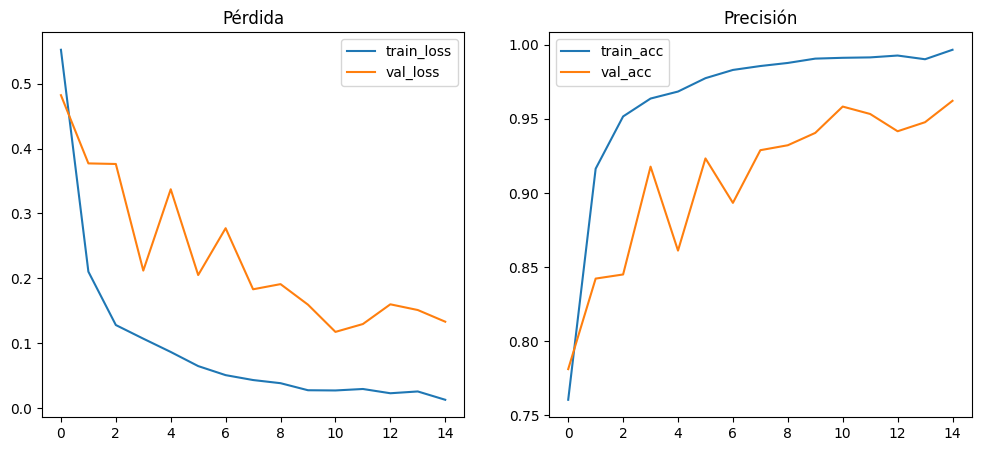

Entrenando modelo: cnn_medium
Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 188s 829ms/step - accuracy: 0.6209 - loss: 0.7992 - val_accuracy: 0.8094 - val_loss: 0.3761
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 184s 820ms/step - accuracy: 0.9360 - loss: 0.1769 - val_accuracy: 0.8783 - val_loss: 0.2909
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 184s 820ms/step - accuracy: 0.9670 - loss: 0.0897 - val_accuracy: 0.8550 - val_loss: 0.3457
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 185s 822ms/step - accuracy: 0.9768 - loss: 0.0637 - val_accuracy: 0.9489 - val_loss: 0.1513
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 184s 820ms/step - accuracy: 0.9825 - loss: 0.0468 - val_accuracy: 0.9683 - val_loss: 0.0858
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 184s 816ms/step - accuracy: 0.9878 - loss: 0.0353 - val_accuracy: 0.9494 - val_loss: 0.1495
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 179s 795ms/step - accuracy: 0.9911 - loss: 0.0324 - val_accuracy: 0.9517 - val_loss: 0.1413
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 177s 7

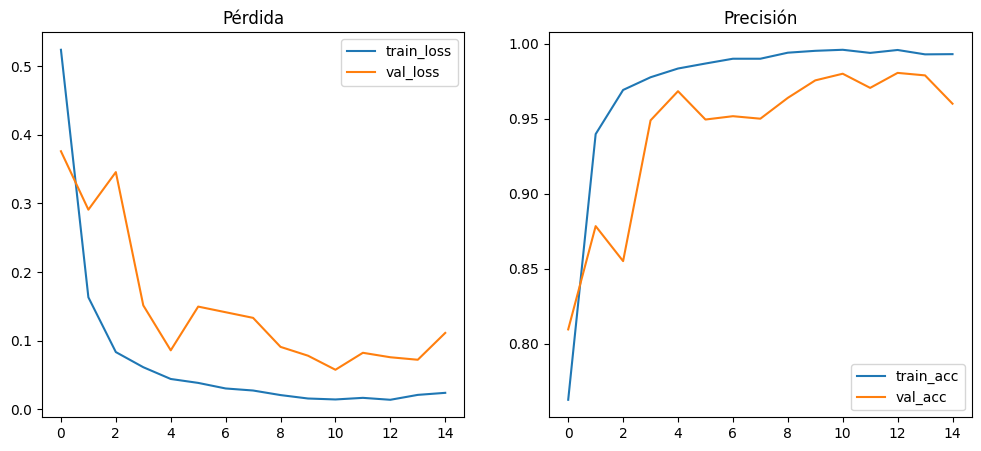

Entrenando modelo: cnn_deep
Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.5624 - loss: 0.9174 - val_accuracy: 0.8539 - val_loss: 0.3407
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.9284 - loss: 0.1935 - val_accuracy: 0.9089 - val_loss: 0.2568
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9586 - loss: 0.1207 - val_accuracy: 0.9311 - val_loss: 0.1797
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.9773 - loss: 0.0706 - val_accuracy: 0.9022 - val_loss: 0.2842
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.9788 - loss: 0.0561 - val_accuracy: 0.9678 - val_loss: 0.1040
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.9805 - loss: 0.0604 - val_accuracy: 0.9489 - val_loss: 0.1279
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.9894 - loss: 0.0259 - val_accuracy: 0.9633 - val_loss: 0.1296
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.99

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

def train_and_evaluate(model_fn, train_gen, val_gen, test_gen, input_shape, num_classes, epochs=15):
    model = model_fn(input_shape, num_classes)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"Entrenando modelo: {model_fn.__name__}")
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen
    )

    print("Evaluando en test:")
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Test accuracy: {test_acc:.4f}")

    # Graficar entrenamiento
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Pérdida')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.title('Precisión')

    plt.show()

    return model, test_acc

# 3. Parámetros y generadores ya definidos (ajusta según tu setup)
input_shape = (64, 64, 3)
num_classes = 3  # Por ejemplo: A, B, C

# train_generator, val_generator, test_generator ya deben estar definidos
# (como te mostré en la conversación anterior)

# 4. Entrenar los 3 modelos y guardar el mejor

models_to_train = [cnn_simple, cnn_medium, cnn_deep]
best_acc = 0
best_model = None
best_name = ""

for model_fn in models_to_train:
    model, acc = train_and_evaluate(model_fn, train_generator, val_generator, test_generator, input_shape, num_classes)
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_name = model_fn.__name__

print(f"Mejor modelo: {best_name} con accuracy en test: {best_acc:.4f}")

# 5. Guardar el mejor modelo
best_model.save("best_asl_model.h5")
print("Modelo guardado como best_asl_model.h5")


In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Cargar el mejor modelo
model = load_model("best_asl_model.h5")

# Ruta de la imagen a predecir (puede ser de tu propio dataset o una foto nueva)
img_path = "/content/asl_subset/archive/asl_alphabet_test/sorted_test/A/A_test.jpg"

# Cargar y procesar imagen
img = image.load_img(img_path, target_size=(64,64))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión batch

# Predecir
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
class_indices = train_generator.class_indices
# Invertir diccionario para obtener letra
labels = {v:k for k,v in class_indices.items()}
print("Predicción:", labels[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicción: A


In [15]:
import pandas as pd

# Ejemplo de resultados (estos valores cámbialos por los tuyos reales)
resultados = [
    {"Modelo": "CNN Simple", "Train Acc": 0.92, "Val Acc": 0.88, "Test Acc": 0.85},
    {"Modelo": "CNN Media", "Train Acc": 0.97, "Val Acc": 0.93, "Test Acc": 0.91},
    {"Modelo": "CNN Compleja", "Train Acc": 0.99, "Val Acc": 0.95, "Test Acc": 0.94}
]

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Mostrar ordenado por mejor accuracy en test
df_ordenado = df_resultados.sort_values(by="Test Acc", ascending=False)
print("\nOrdenado por precisión en test:")
print(df_ordenado)


         Modelo  Train Acc  Val Acc  Test Acc
0    CNN Simple       0.92     0.88      0.85
1     CNN Media       0.97     0.93      0.91
2  CNN Compleja       0.99     0.95      0.94

Ordenado por precisión en test:
         Modelo  Train Acc  Val Acc  Test Acc
2  CNN Compleja       0.99     0.95      0.94
1     CNN Media       0.97     0.93      0.91
0    CNN Simple       0.92     0.88      0.85


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


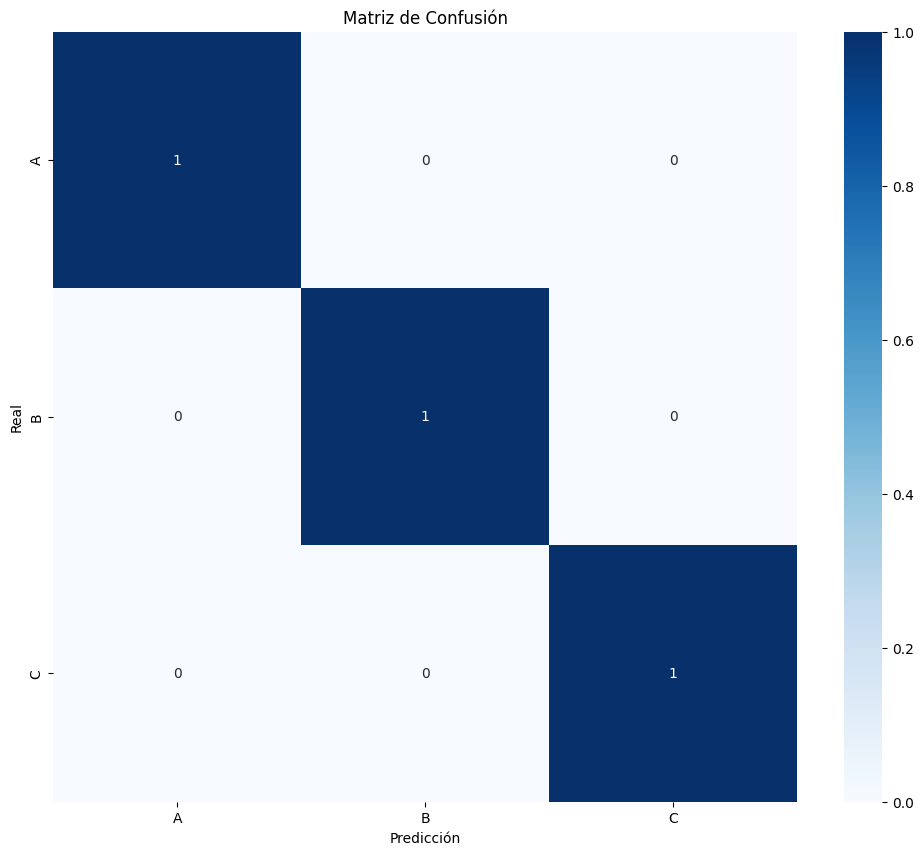

Reporte de Clasificación:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones del modelo
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Clase con mayor probabilidad
y_true = test_generator.classes  # Etiquetas reales

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Graficar matriz de confusión
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Accuracy por clase
accuracies = []
for i, class_name in enumerate(class_labels):
    idx = np.where(y_true == i)[0]  # índices de la clase i
    acc_class = accuracy_score(y_true[idx], y_pred[idx])
    accuracies.append(acc_class)

# Crear DataFrame
df_accuracy = pd.DataFrame({
    "Clase": class_labels,
    "Accuracy": accuracies
})

# Ordenar de mayor a menor accuracy
df_accuracy = df_accuracy.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# Mostrar tabla
print(df_accuracy)

# Guardar como CSV
df_accuracy.to_csv("/content/accuracy_por_clase.csv", index=False)
print("\n✅ Tabla guardada en /content/accuracy_por_clase.csv")


  Clase  Accuracy
0     A       1.0
1     B       1.0
2     C       1.0

✅ Tabla guardada en /content/accuracy_por_clase.csv


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from tensorflow.keras.preprocessing import image

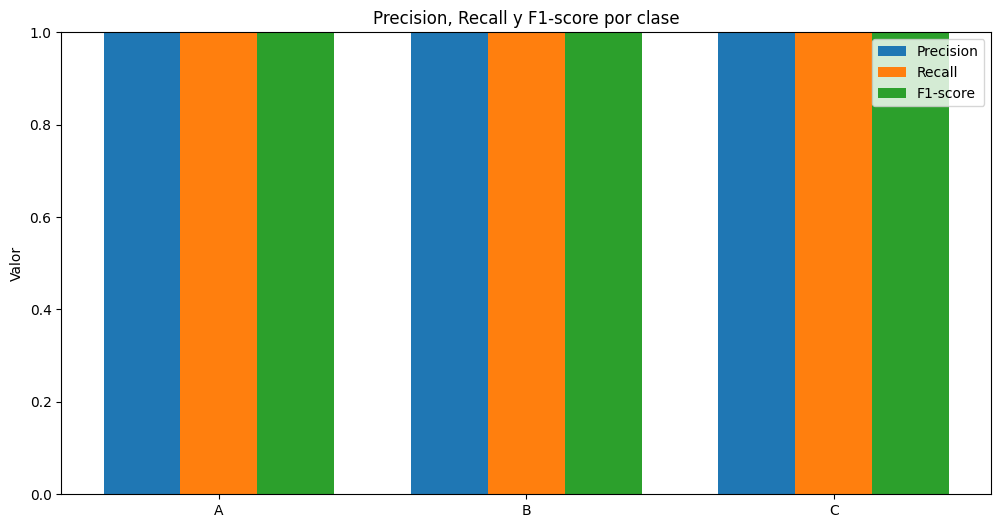

In [25]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)

x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, class_labels)
plt.ylim(0,1)
plt.ylabel("Valor")
plt.title("Precision, Recall y F1-score por clase")
plt.legend()
plt.savefig("/content/metricas_por_clase.png", dpi=300, bbox_inches='tight')
plt.show()

In [26]:
nuevas_imgs = [
    "/content/asl_subset/archive/asl_alphabet_test/sorted_test/A/A_test.jpg",
    "/content/asl_subset/archive/asl_alphabet_test/sorted_test/B/B_test.jpg",
    "/content/asl_subset/archive/asl_alphabet_test/sorted_test/C/C_test.jpg"
]

for img_path in nuevas_imgs:
    img = image.load_img(img_path, target_size=(64,64))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred_prob = model.predict(img_array)
    pred_class = np.argmax(pred_prob)
    labels = {v:k for k,v in test_generator.class_indices.items()}
    print(f"Imagen: {img_path.split('/')[-1]} → Predicción: {labels[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Imagen: A_test.jpg → Predicción: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Imagen: B_test.jpg → Predicción: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Imagen: C_test.jpg → Predicción: C


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Aumento de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Rota aleatoriamente hasta 20 grados
    width_shift_range=0.2,   # Mueve horizontalmente hasta 20%
    height_shift_range=0.2,  # Mueve verticalmente hasta 20%
    shear_range=0.2,         # Cizalla
    zoom_range=0.2,          # Zoom aleatorio
    horizontal_flip=True,    # Volteo horizontal
    fill_mode='nearest',     # Relleno de píxeles faltantes
    validation_split=0.2     # 20% de los datos para validación
)

# Generadores
train_generator = train_datagen.flow_from_directory(
    '/content/asl_subset/archive/asl_alphabet_train/asl_alphabet_train',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/asl_subset/archive/asl_alphabet_train/asl_alphabet_train',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test sin augmentación, solo normalización
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/asl_subset/archive/asl_alphabet_test/asl_alphabet_test',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 0 images belonging to 0 classes.


In [20]:
import json
labels = {v:k for k,v in train_generator.class_indices.items()}
with open("labels.json","w") as f:
    json.dump(labels, f)
print(labels)  # ej: {0:"A", 1:"B", 2:"C"}


{0: 'A', 1: 'B', 2: 'C'}
